# Figure 1: Motif type distribution

# Setup

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from rna_motif_library.settings import DATA_PATH
from rna_motif_library.util import add_motif_indentifier_columns
from rna_motif_library.plotting import publication_style_ax

PLOT_PATH = "../../figures/plots"

## extra functions


In [2]:
def add_residue_count(df: pd.DataFrame) -> pd.DataFrame:
    """Add a column counting non-gap residues in each sequence.

    Args:
        df: DataFrame containing motif data with 'msequence' column

    Returns:
        DataFrame with additional 'residue_num' column counting non-gap characters
    """
    df["residue_num"] = df["msequence"].str.replace("-", "").str.len()
    return df


def rename_motif_types(df):
    """Rename motif type values to more readable format.

    Args:
        df: DataFrame containing motif data

    Returns:
        DataFrame with renamed motif types
    """
    type_mapping = {
        "HELIX": "Helix",
        "SSTRAND": "Single Strand",
        "TWOWAY": "Two-way",
        "NWAY": "N-way",
        "HAIRPIN": "Hairpin",
    }

    df["motif_type"] = df["motif_type"].map(type_mapping)
    return df

## load data

In [3]:
path = "../../data/summaries/non_redundant_motifs_no_issues.csv"
df = pd.read_csv(path)
df = add_motif_indentifier_columns(df, "motif_name")
df = df.query("mtype != 'UNKNOWN'")
df = add_residue_count(df)
# Apply the renaming
df = rename_motif_types(df)

# Plots

## Figure 1a: Motif type counts

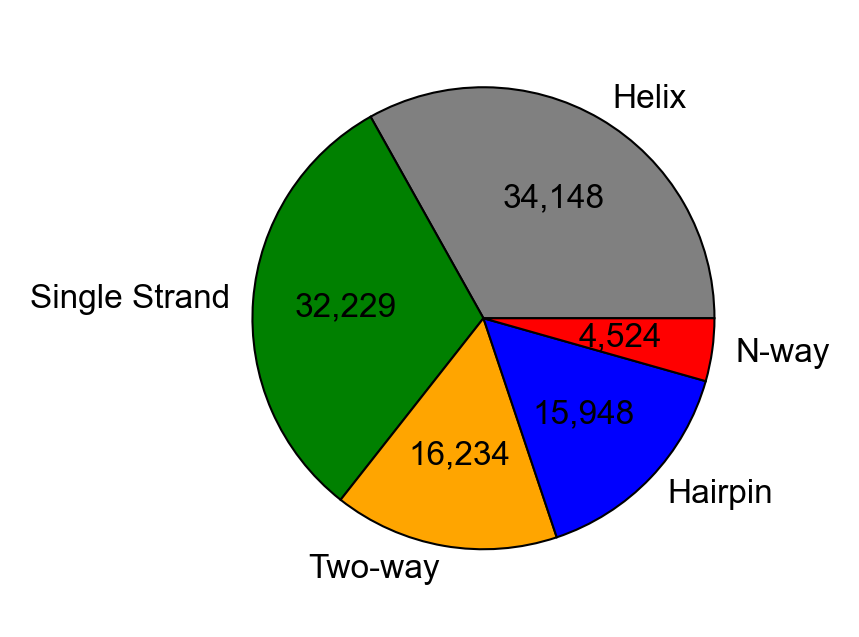

In [4]:
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
colors = {
    "Helix": "gray",
    "N-way": "red",
    "Two-way": "orange",
    "Hairpin": "blue",
    "Single Strand": "green",
}
value_counts = df["motif_type"].value_counts()
value_counts.plot(
    kind="pie",
    ax=ax,
    colors=[colors[m] for m in value_counts.index],
    wedgeprops={"edgecolor": "black", "linewidth": 0.5},
    autopct=lambda p: f"{int(p * len(df)/100):,}",
)
ax.set_ylabel("")
publication_style_ax(ax)
fig.savefig(os.path.join(PLOT_PATH, "Figure_1a.png"))

## Figure 1b: distribution of helix sizes

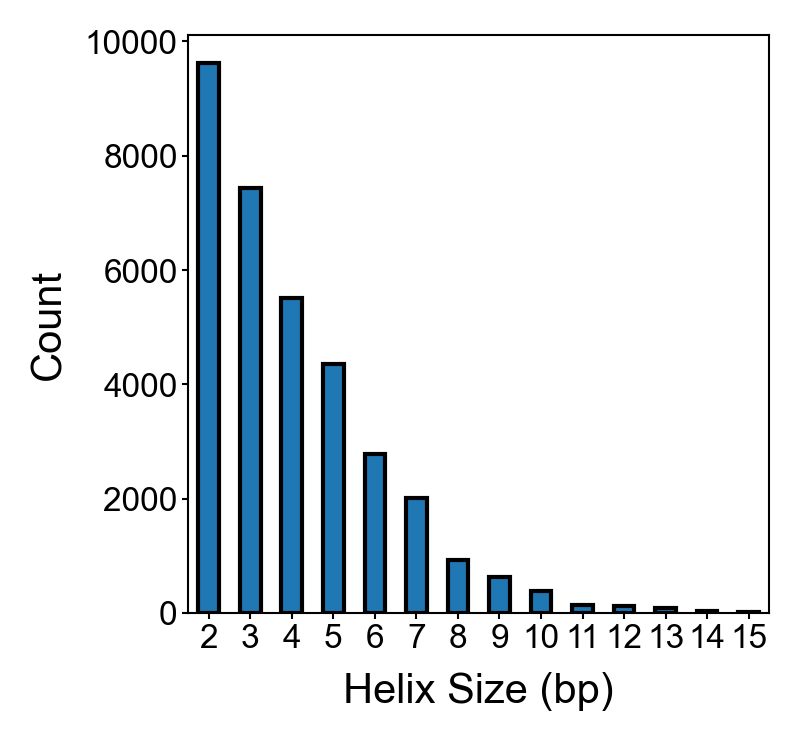

In [7]:
# Get helices and their sizes
helices = df.query("motif_type == 'Helix'").copy()
helices["msize"] = helices["msize"].astype(int)
helix_sizes = helices["msize"].astype(int).value_counts()
helix_sizes = helix_sizes[helix_sizes.index <= 15]  # Only keep sizes up to 15

# Create bar plot of helix sizes
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
helix_sizes.plot(kind="bar", ax=ax, edgecolor="black")
ax.set_xlabel("Helix Size (bp)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")

ax.set_ylabel("Count")
publication_style_ax(ax)
fig.savefig(os.path.join(PLOT_PATH, "Figure_1b.png"), bbox_inches="tight")

In [10]:
# Calculate cumulative counts for helix sizes
cumulative_counts = helix_sizes.sort_index().cumsum()
print(cumulative_counts / helix_sizes.sum())

msize
2     0.282673
3     0.500969
4     0.662790
5     0.790661
6     0.872276
7     0.931395
8     0.958796
9     0.977269
10    0.988488
11    0.992628
12    0.995947
13    0.998385
14    0.999471
15    1.000000
Name: count, dtype: float64


## Hairpin size distribution

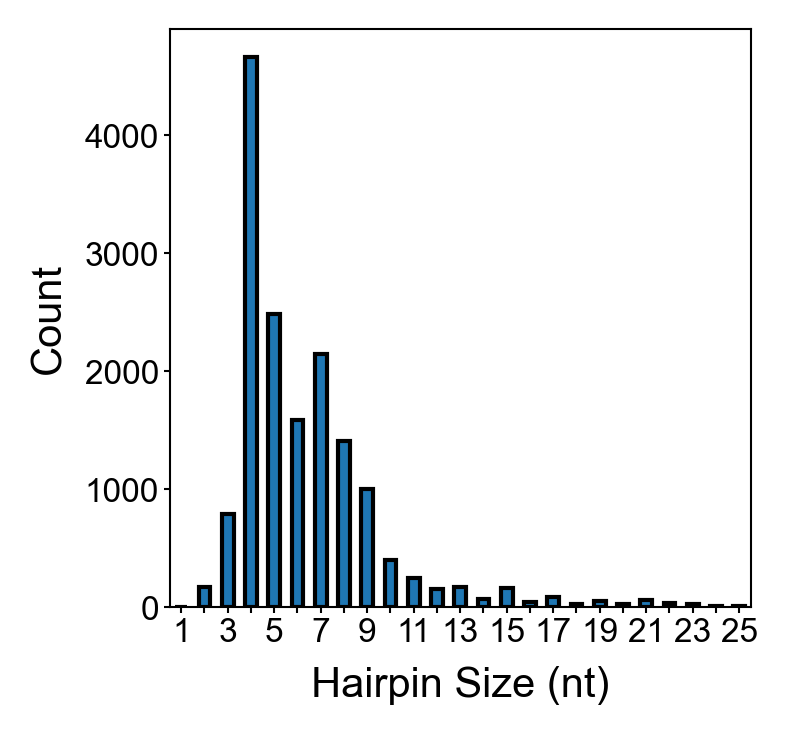

In [11]:
# Get hairpins and their sizes
hairpins = df.query("motif_type == 'Hairpin'").copy()
hairpins["msize"] = hairpins["msize"].astype(int)
hairpins = hairpins.query("msize <= 25")
hairpin_sizes = hairpins["msize"].value_counts().sort_index()

# Create bar plot of hairpin sizes
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
hairpin_sizes = hairpins["msize"].value_counts().sort_index()
hairpin_sizes.plot(kind="bar", ax=ax, edgecolor="black")
ax.set_xlabel("Hairpin Size (nt)")

# Label every other bar
labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(hairpin_sizes.index)]
ax.set_xticklabels(labels, rotation=0)

ax.set_ylabel("Count")
publication_style_ax(ax)
fig.savefig(os.path.join(PLOT_PATH, "Figure_1c.png"), bbox_inches="tight")

In [13]:
hairpins.query("msize <= 1")

,motif_name,motif_type,flanking_helices,contains_helix,has_singlet_pair,has_singlet_pair_end,mtype,msize,msequence,pdb_id,residue_num
60656,HAIRPIN-1-CGG-7PWO-1,Hairpin,1.0,0.0,0.0,0.0,HAIRPIN,1,CGG,7PWO,3
60706,HAIRPIN-1-CGG-7PWF-1,Hairpin,1.0,0.0,0.0,0.0,HAIRPIN,1,CGG,7PWF,3


## Single strand size distribution

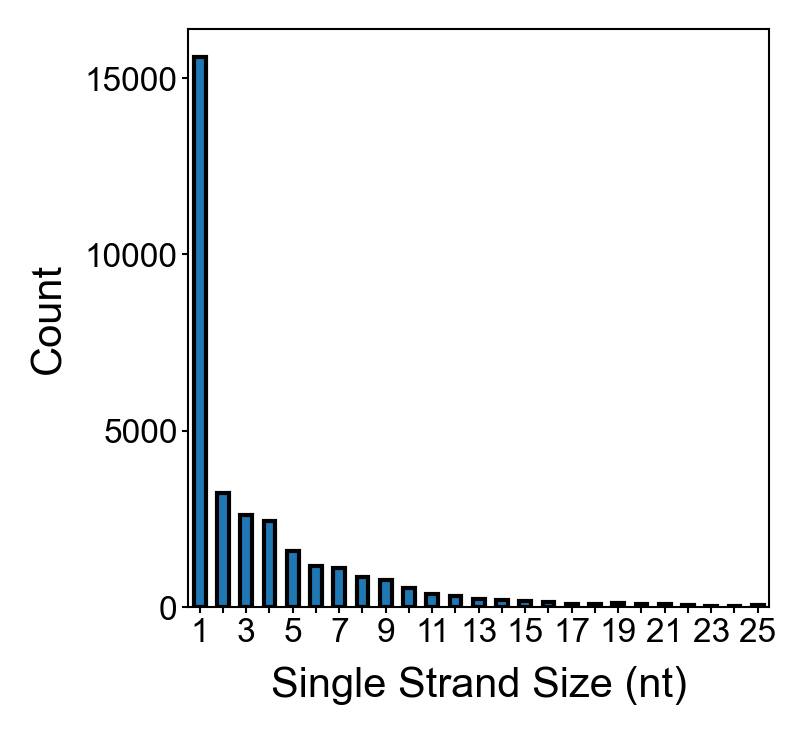

In [16]:
# Get single strands and their sizes
singles = df.query("mtype == 'SSTRAND'").copy()
singles["msize"] = singles["msize"].astype(int)
singles = singles.query("msize <= 25")
single_sizes = singles["msize"].astype(int).value_counts()

# Create bar plot of single strand sizes
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
single_sizes = singles["msize"].value_counts().sort_index()
single_sizes.plot(kind="bar", ax=ax, edgecolor="black")
ax.set_xlabel("Single Strand Size (nt)")

# Label every other bar
labels = [str(x) if i % 2 == 0 else "" for i, x in enumerate(single_sizes.index)]
ax.set_xticklabels(labels, rotation=0)

ax.set_ylabel("Count")
publication_style_ax(ax)
fig.savefig(os.path.join(PLOT_PATH, "Figure_1d.png"), bbox_inches="tight")

## Two-way junction size distribution

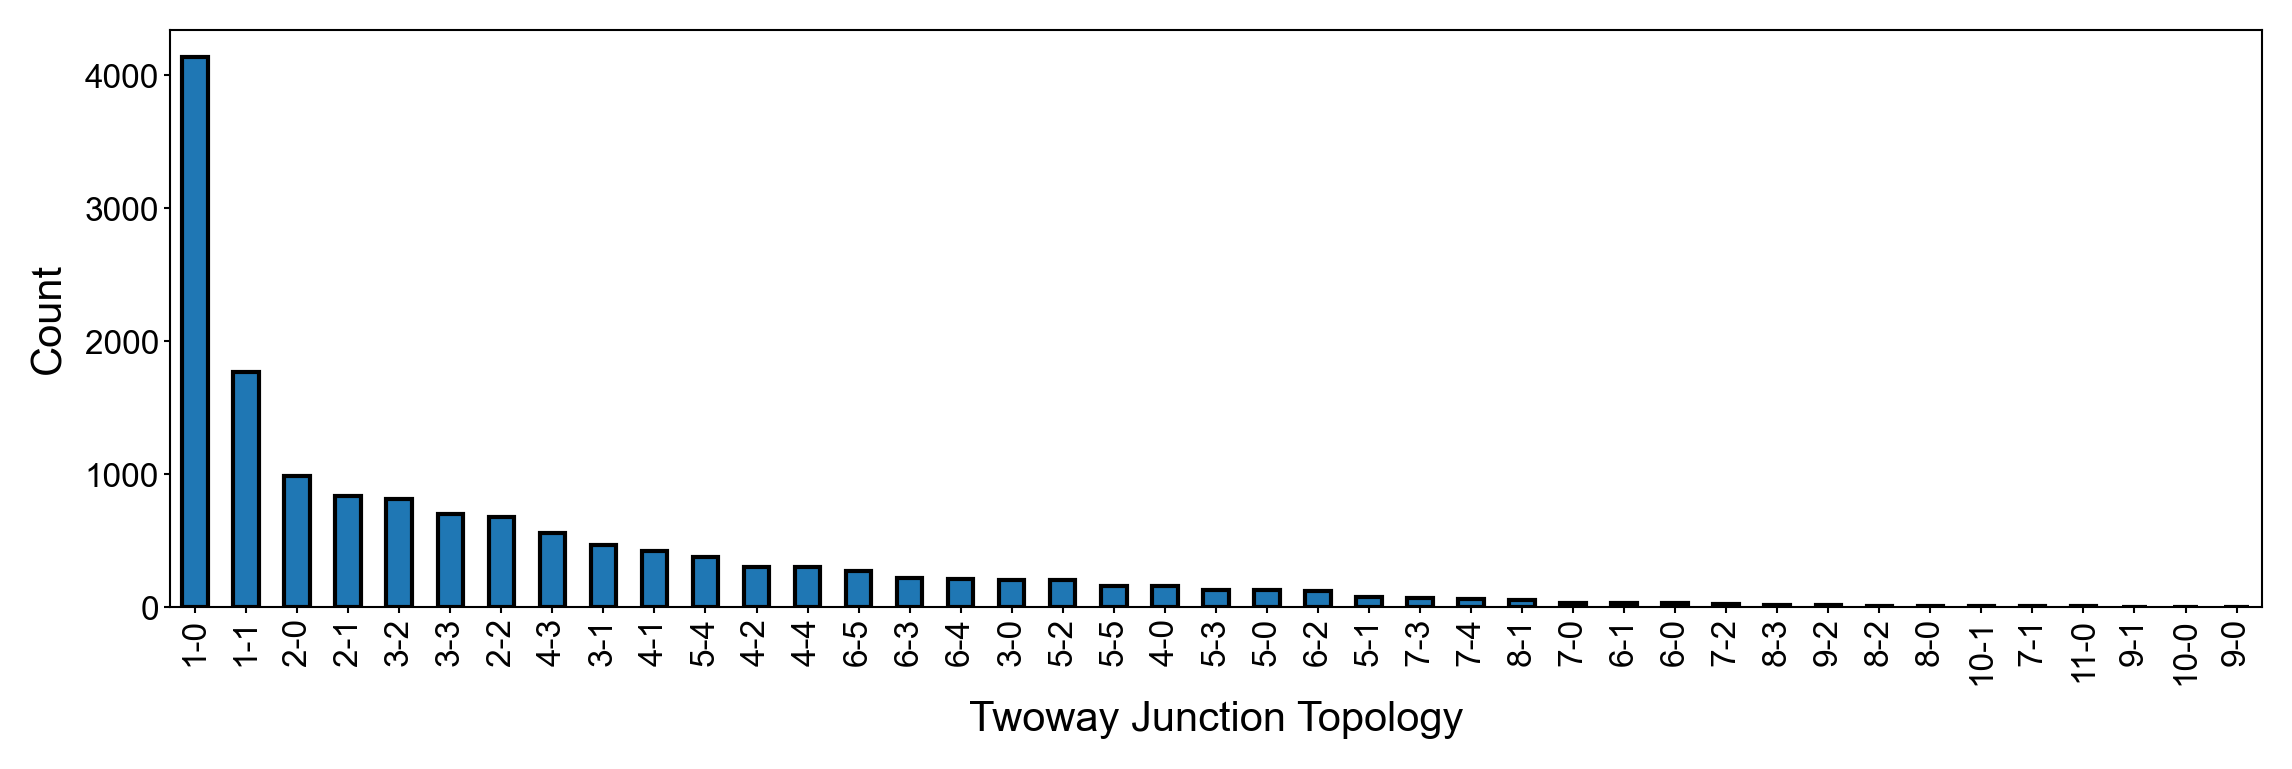

In [37]:
# Get TWOWAY motifs and their sizes
twoways = df.query("motif_type == 'Two-way'").copy()
twoways = add_residue_count(twoways)
twoways = twoways.query("residue_num <= 15")
twoway_sizes = twoways["msize"].value_counts()

# Create bar plot of twoway sizes
fig, ax = plt.subplots(figsize=(9.0, 2.5), dpi=300)
twoway_sizes.plot(kind="bar", ax=ax, edgecolor="black")
ax.set_xlabel("Twoway Junction Topology")

# Label every other bar
labels = [str(x) for x in twoway_sizes.index]
ax.set_xticklabels(labels, rotation=90)

# Remove tick marks
ax.tick_params(axis="x", size=0)

ax.set_ylabel("Count")
publication_style_ax(ax)
fig.savefig(os.path.join(PLOT_PATH, "Figure_1e.png"), bbox_inches="tight")

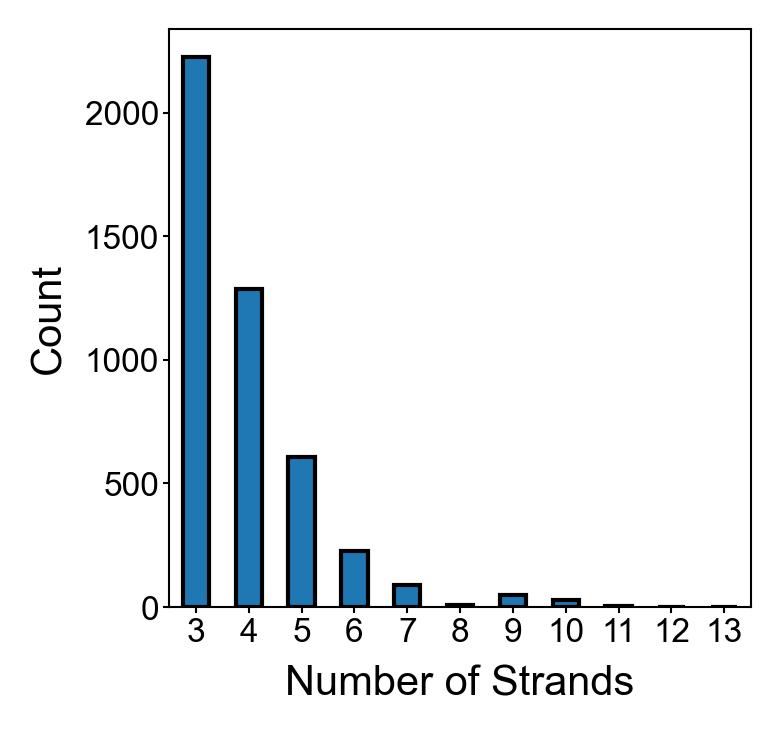

In [35]:
# Get NWAY motifs and count number of strands
nways = df.query("motif_type == 'N-way'").copy()
# Count number of strands by counting "-" in sequence and adding 1
nways["num_strands"] = nways["msequence"].str.count("-") + 1
strand_counts = nways["num_strands"].value_counts().sort_index()

# Create bar plot of number of strands
fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=300)
strand_counts.plot(kind="bar", ax=ax, edgecolor="black")
ax.set_xlabel("Number of Strands")

# Label every bar since there will be fewer bars
ax.set_xticklabels([str(x) for x in strand_counts.index], rotation=0)

ax.set_ylabel("Count")
publication_style_ax(ax)
fig.savefig(os.path.join(PLOT_PATH, "Figure_1f.png"), bbox_inches="tight")